## Вопрос №2

**Из открытых источников загрузите датасет который авторы анализировали в публикации. Пример одного образца https://www.ncbi.nlm.nih.gov/gds?LinkName=biosample_gds&from_uid=12643370. Скрипт для загрузки оформите в виде скрипта на языке Python или R, можно в формате jupyter notebook.**

**Предложите метод для загрузки полного датасета с ресурса GEO (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE125449). достаточно описать принцип**

Все записи GEO и файлы необработанных данных можно загрузить с FTP-сайта, составив запрос типа https://ftp.ncbi.nlm.nih.gov/geo/series/GSEXXXnnn/GSEXXXxxx/...
где GSEXXXxxx - series_id, который можно посмотреть, например, на странице самого датасета. 
С этой страницы доступны 4 директории: series_matrix, soft, miniml содержат общую информацию об эксперименте и образцах, метаданные, номер серии, номера образцов, ссылки на загрузку файлов supplementary_data, итд. Папка suppl содержит сами наборы данных в виде архивов gz. 

В данном случае series_id - GSE125449, соотвественно ссылки для доступа к файлам будут выглядеть как:

https://ftp.ncbi.nlm.nih.gov/geo/series/GSE125nnn/GSE125449/soft/
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE125nnn/GSE125449/miniml/
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE125nnn/GSE125449/matrix/
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE125nnn/GSE125449/suppl/

Скрипт для загрузки всех файлов может выглядеть следующим образом:

In [2]:
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import re

In [3]:
search_pages=['https://ftp.ncbi.nlm.nih.gov/geo/series/GSE125nnn/GSE125449/soft/',\
               'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE125nnn/GSE125449/miniml/',\
               'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE125nnn/GSE125449/matrix/',\
               'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE125nnn/GSE125449/suppl/']

In [4]:
def parselinks(page):
    html = urllib.request.urlopen(page).read()
    soup = BeautifulSoup(html, 'html.parser')
    link_list=list()
    for link in soup.find_all('a'):
        href=re.findall('href="(GSE[0-9].+?)"',str(link))
        if href!=[]:
            full_url=page+href[0]
            link_list.append(full_url)
    return link_list

In [5]:
for page in search_pages:
    links=parselinks(page)
    for link in links:
        name=link.split('/')[-1:][0]
        urllib.request.urlretrieve(link,name)

После выполнения скрипта все файлы из папок будут скачаны в рабочую директрию.

Во время работы с файлами я буду использовать пакет scanpy, созданный для анализа данных экспрессии генов в одиночных клетках. Все последующие шаги будут выполнены на примере набора 1.

## Вопрос №4

**Проведите оценку качества загруженного датасета. Отфильтруйте дуплеты. Оформите  скрипт на языке Python или R, можно в формате jupyter notebook**

In [33]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import  matplotlib.pyplot  as  plt 
%matplotlib inline

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.9.1 pandas==1.4.3 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
adata = sc.read_10x_mtx(
    path="workfiles/",
    var_names='gene_symbols', 
    cache=True, prefix='GSE125449_Set1_')

... reading from cache file cache/workfiles-GSE125449_Set1_matrix.h5ad


In [4]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
qc=sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], log1p=False)
qc_cells=qc[0]
qc_genes=qc[1]

In [5]:
qc_cells

,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,pct_counts_mito
AAACCTGAGGCGTACA-1,909,2235.0,42.237136,54.541387,65.995526,81.700224,131.0,5.861298
AAACGGGAGATCGATA-1,1266,3555.0,36.736990,49.901547,62.981716,78.452883,134.0,3.769339
AAAGCAAAGATCGGGT-1,2495,7751.0,29.363953,41.220488,53.644691,68.481486,401.0,5.173526
AAATGCCGTCTCAACA-1,1100,3168.0,41.698232,53.219697,65.277778,81.060606,148.0,4.671717
AACACGTCACGGCTAC-1,1096,2040.0,30.931373,41.666667,53.284314,70.784314,37.0,1.813726
...,...,...,...,...,...,...,...,...
TTGACTTTCCAGTAGT-13,1316,2799.0,27.617006,39.406931,52.232940,70.846731,72.0,2.572347
TTGCCGTCATCGACGC-13,6054,63362.0,31.514157,43.085761,55.643761,70.348158,2328.0,3.674126
TTGGAACTCGAACTGT-13,2941,12340.0,48.144246,56.304700,64.837925,74.918963,2074.0,16.807131
TTTATGCTCCTTAATC-13,1014,1857.0,33.225633,43.187938,54.873452,72.320948,97.0,5.223479


In [6]:
qc_genes

,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13.7,12,0.002346,99.765396,12.0
FO538757.2,970,0.253763,81.036168,1298.0
AP006222.2,494,0.123363,90.342131,631.0
RP4-669L17.10,26,0.005083,99.491691,26.0
RP5-857K21.4,7,0.001369,99.863148,7.0
...,...,...,...,...
AL354822.1,87,0.018573,98.299120,95.0
AC004556.1,144,0.043011,97.184751,220.0
AC233755.2,11,0.022092,99.784946,113.0
AC233755.1,71,0.021505,98.611926,110.0


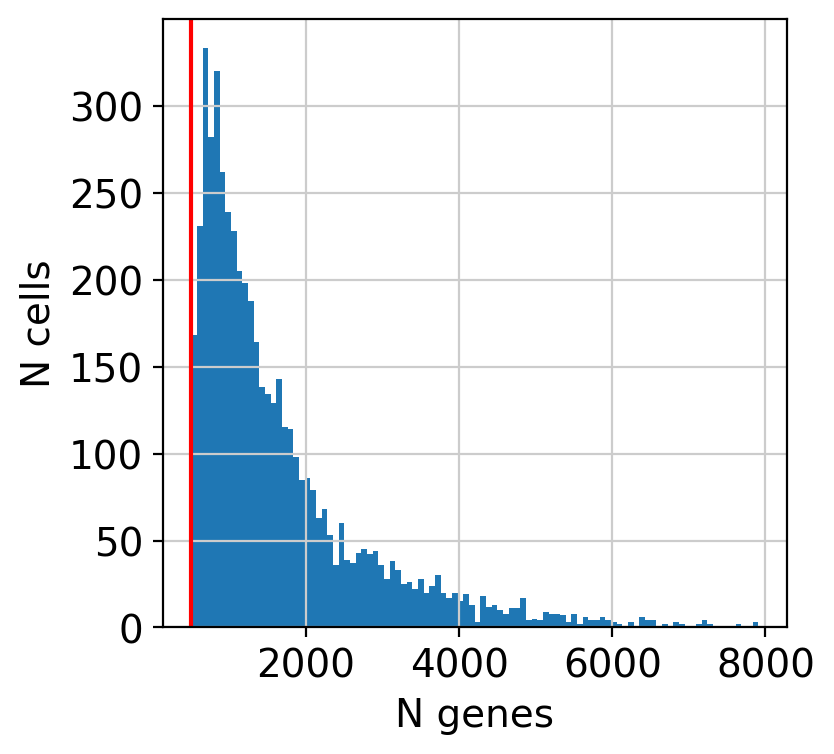

In [7]:
#контроль качества
#количество генов на клетку
plt.hist(qc_cells['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(500, color='red')

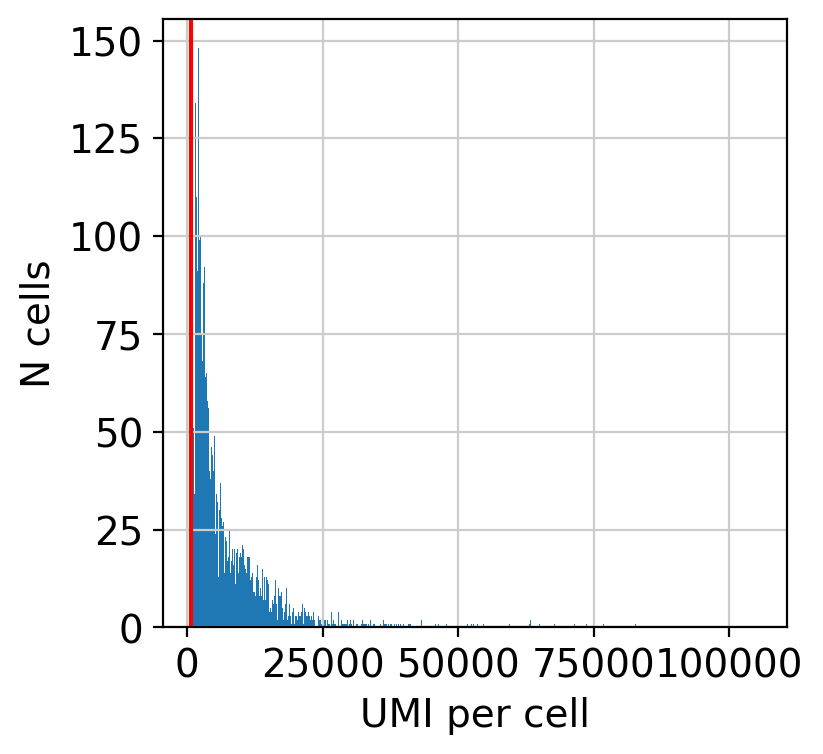

In [8]:
#количество UMI
plt.hist(qc_cells['total_counts'], bins=1000)
plt.xlabel('UMI per cell')
plt.ylabel('N cells')
plt.axvline(700, color='red')

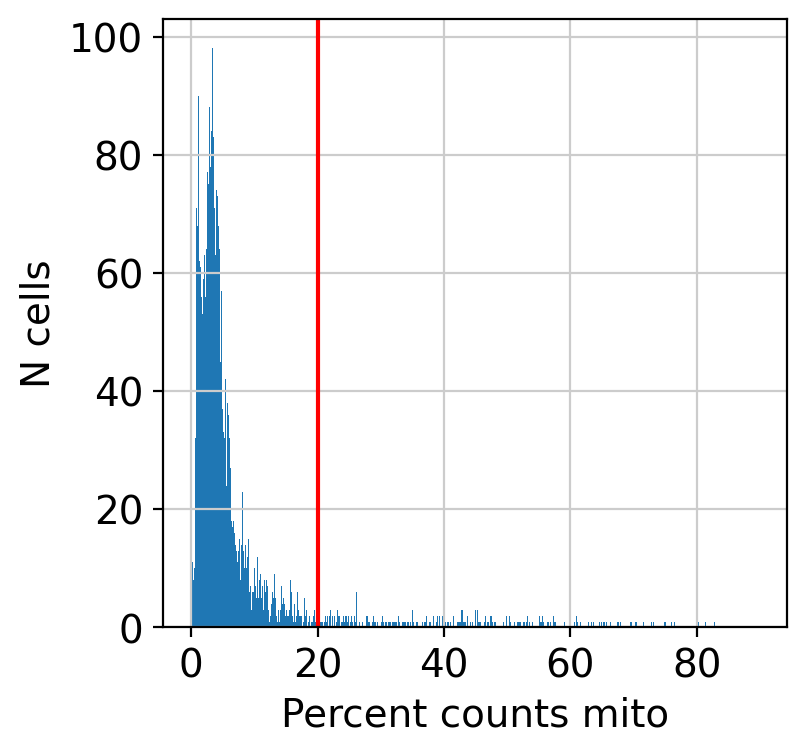

In [9]:
#митохондриальные гены на клетку
plt.hist(qc_cells['pct_counts_mito'], bins=1000)
plt.xlabel('Percent counts mito')
plt.ylabel('N cells')
plt.axvline(20, color='red')

In [10]:
data_process=adata.copy()

In [11]:
sc.pp.filter_cells(data_process, min_genes = 500)

In [12]:
data_process.n_obs    #по видимому, в загруженном датасете уже удалены клетки с количеством генов < 500

5115

In [13]:
sc.pp.filter_cells(data_process, min_counts = 700)

In [14]:
data_process.n_obs     #фильтрация по количству UMI также не изменила состав датасета

5115

In [15]:
#предсказание количества дублетов с учетом multiplet rate 0,4%
doublets=sce.pp.scrublet(adata, expected_doublet_rate=0.4, copy=True)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 23.8%
Overall doublet rate:
	Expected   = 40.0%
	Estimated  = 3.1%
    Scrublet finished (0:00:10)


In [16]:
#функция предсказывает 38 дублетов
doublets.obs.groupby('predicted_doublet').agg({'predicted_doublet':'count'}).rename(columns={'predicted_doublet':'count'})

,count
predicted_doublet,
False,5077
True,38


In [17]:
droped_dublets = (doublets.obs['predicted_doublet'] == False)
data_process = data_process[droped_dublets]

In [18]:
data_process.n_obs

5077

In [19]:
#пересчет характеристик данных и фильтрация по проценту митохондриальных генов
recalq_qc=sc.pp.calculate_qc_metrics(data_process, qc_vars=["mito"], log1p=False)
recalq_cells=recalq_qc[0]
recalq_genes=recalq_qc[1]

In [20]:
low_mito = (recalq_cells['pct_counts_mito'] < 20)
data_process = data_process[low_mito]

In [21]:
data_process.n_obs     #после фильтрации по % митохондриальных генов еще часть клеток была удалена

4719

## Вопрос №5

**Проведите нормализацию, отфильтруйте вариабельные гены, оформите  скрипт на языке Python или R, можно в формате jupyter notebook**

In [22]:
#добавим информацию о типах клеток и образцах для дальнейшей группировки
sample_data=pd.read_csv('GSE125449_Set1_samples.csv',sep='\t')
sample_data=sample_data.rename(columns={'Sample':'sample', 'Cell Barcode':'cell_barcode', 'Type':'cell_type'})
sample_data

,sample,cell_barcode,cell_type
0,S02_P01_LCP21,AAACCTGAGGCGTACA-1,CAF
1,S02_P01_LCP21,AAACGGGAGATCGATA-1,CAF
2,S02_P01_LCP21,AAAGCAAAGATCGGGT-1,CAF
3,S02_P01_LCP21,AAATGCCGTCTCAACA-1,CAF
4,S02_P01_LCP21,AACACGTCACGGCTAC-1,TEC
...,...,...,...
5110,S21_P13_LCP37,TTGACTTTCCAGTAGT-13,T cell
5111,S21_P13_LCP37,TTGCCGTCATCGACGC-13,Malignant cell
5112,S21_P13_LCP37,TTGGAACTCGAACTGT-13,Malignant cell
5113,S21_P13_LCP37,TTTATGCTCCTTAATC-13,Malignant cell


In [23]:
cells_info=recalq_cells.reset_index().rename(columns={'index':'cell_barcode'}).drop(['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'], axis=1)
cells_info=cells_info.merge(sample_data, on='cell_barcode', how='left')
for_colors=cells_info.set_index('cell_barcode')
for_colors

,n_genes_by_counts,total_counts,total_counts_mito,pct_counts_mito,sample,cell_type
cell_barcode,,,,,,
AAACCTGAGGCGTACA-1,909,2235.0,131.0,5.861298,S02_P01_LCP21,CAF
AAACGGGAGATCGATA-1,1266,3555.0,134.0,3.769339,S02_P01_LCP21,CAF
AAAGCAAAGATCGGGT-1,2495,7751.0,401.0,5.173526,S02_P01_LCP21,CAF
AAATGCCGTCTCAACA-1,1100,3168.0,148.0,4.671717,S02_P01_LCP21,CAF
AACACGTCACGGCTAC-1,1096,2040.0,37.0,1.813726,S02_P01_LCP21,TEC
...,...,...,...,...,...,...
TTGACTTTCCAGTAGT-13,1316,2799.0,72.0,2.572347,S21_P13_LCP37,T cell
TTGCCGTCATCGACGC-13,6054,63362.0,2328.0,3.674126,S21_P13_LCP37,Malignant cell
TTGGAACTCGAACTGT-13,2941,12340.0,2074.0,16.807131,S21_P13_LCP37,Malignant cell


In [24]:
norm_data=data_process.copy()
norm_data

AnnData object with n_obs × n_vars = 4719 × 20124
    obs: 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mito'

In [25]:
norm_data.obs["cell_types"] = for_colors['cell_type']
norm_data.obs["samples"] = for_colors['sample']
norm_data.obs

,n_genes,n_counts,cell_types,samples
AAACCTGAGGCGTACA-1,909,2235.0,CAF,S02_P01_LCP21
AAACGGGAGATCGATA-1,1266,3555.0,CAF,S02_P01_LCP21
AAAGCAAAGATCGGGT-1,2495,7751.0,CAF,S02_P01_LCP21
AAATGCCGTCTCAACA-1,1100,3168.0,CAF,S02_P01_LCP21
AACACGTCACGGCTAC-1,1096,2040.0,TEC,S02_P01_LCP21
...,...,...,...,...
TTGACTTTCCAGTAGT-13,1316,2799.0,T cell,S21_P13_LCP37
TTGCCGTCATCGACGC-13,6054,63362.0,Malignant cell,S21_P13_LCP37
TTGGAACTCGAACTGT-13,2941,12340.0,Malignant cell,S21_P13_LCP37
TTTATGCTCCTTAATC-13,1014,1857.0,Malignant cell,S21_P13_LCP37


In [26]:
# нормализация до 10000 транскриптов на клетку
sc.pp.normalize_total(norm_data, target_sum=1e4, exclude_highly_expressed=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100A9', 'S100A8', 'S100A6', 'APOA2', 'TMSB10', 'IGKC', 'MTRNR2L12', 'IGFBP7', 'JCHAIN', 'ALB', 'TMSB4X', 'TIMP1', 'MTRNR2L10', 'CCL19', 'HBB', 'MTRNR2L8', 'SAA2', 'SAA1', 'FTH1', 'MALAT1', 'APOC3', 'LYZ', 'SERPINA1', 'IGHA2', 'IGHG4', 'IGHG2', 'IGHGP', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHV3-23', 'B2M', 'HBA2', 'HBA1', 'HP', 'MTRNR2L1', 'APOE', 'FTL', 'IGLC2', 'IGLC3', 'TFF3', 'TFF1', 'MT-CO1', 'MT-CO2']
    finished (0:00:00)


In [27]:
# приведение к виду X=log(x+1)
sc.pp.log1p(norm_data)

In [28]:
# выявление вариабельных генов
sc.pp.highly_variable_genes(norm_data, min_disp=0.5, min_mean=0.05, max_mean=3, span=0.3, n_bins=20, flavor='seurat', inplace=True)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [30]:
# топ-20 высоковариабельных генов
# нормализованная дисперсия получается путем масштабирования со средним значением и стандартным отклонением 
# дисперсий для генов, попадающих в заданный интервал для средней экспрессии генов
var_genes=norm_data.var.query('highly_variable==True').sort_values('dispersions_norm',ascending=False).head(20).drop(['gene_ids', 'feature_types', 'mito'], axis=1)
var_genes

,highly_variable,means,dispersions,dispersions_norm
IGHV3-15,True,0.175209,6.768375,12.234248
HBD,True,0.222061,6.110965,10.724908
IGLV4-69,True,0.339248,6.008101,10.488745
PSCA,True,0.173843,5.826636,10.072120
IGHV3-43,True,0.750134,6.884022,9.606978
SAA2,True,0.589578,6.869116,9.579426
AHSP,True,0.124660,5.383788,9.055390
IGHV1-18,True,0.150066,5.234153,8.711844
CA1,True,0.123469,5.206666,8.648739
HBM,True,0.061257,5.183434,8.595401


In [31]:
# построим графики главных компонентов (высоковариабельные гены будут отфильтрованы автоматически)
sc.pp.pca(norm_data, n_comps=20)

computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:00)


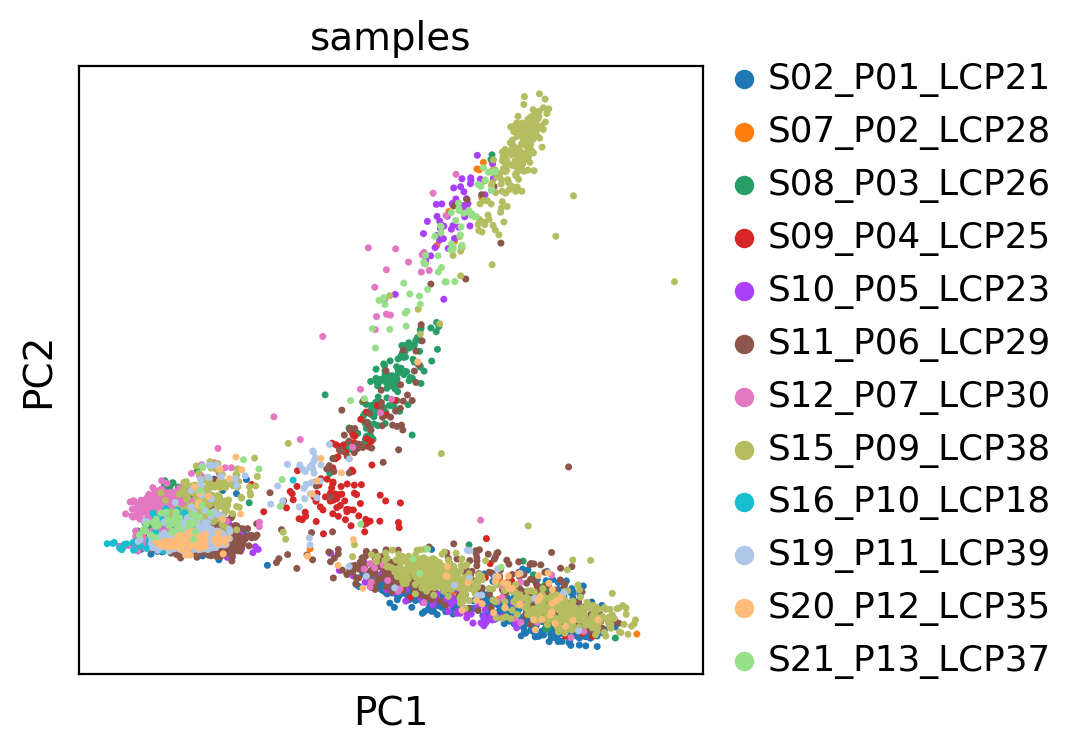

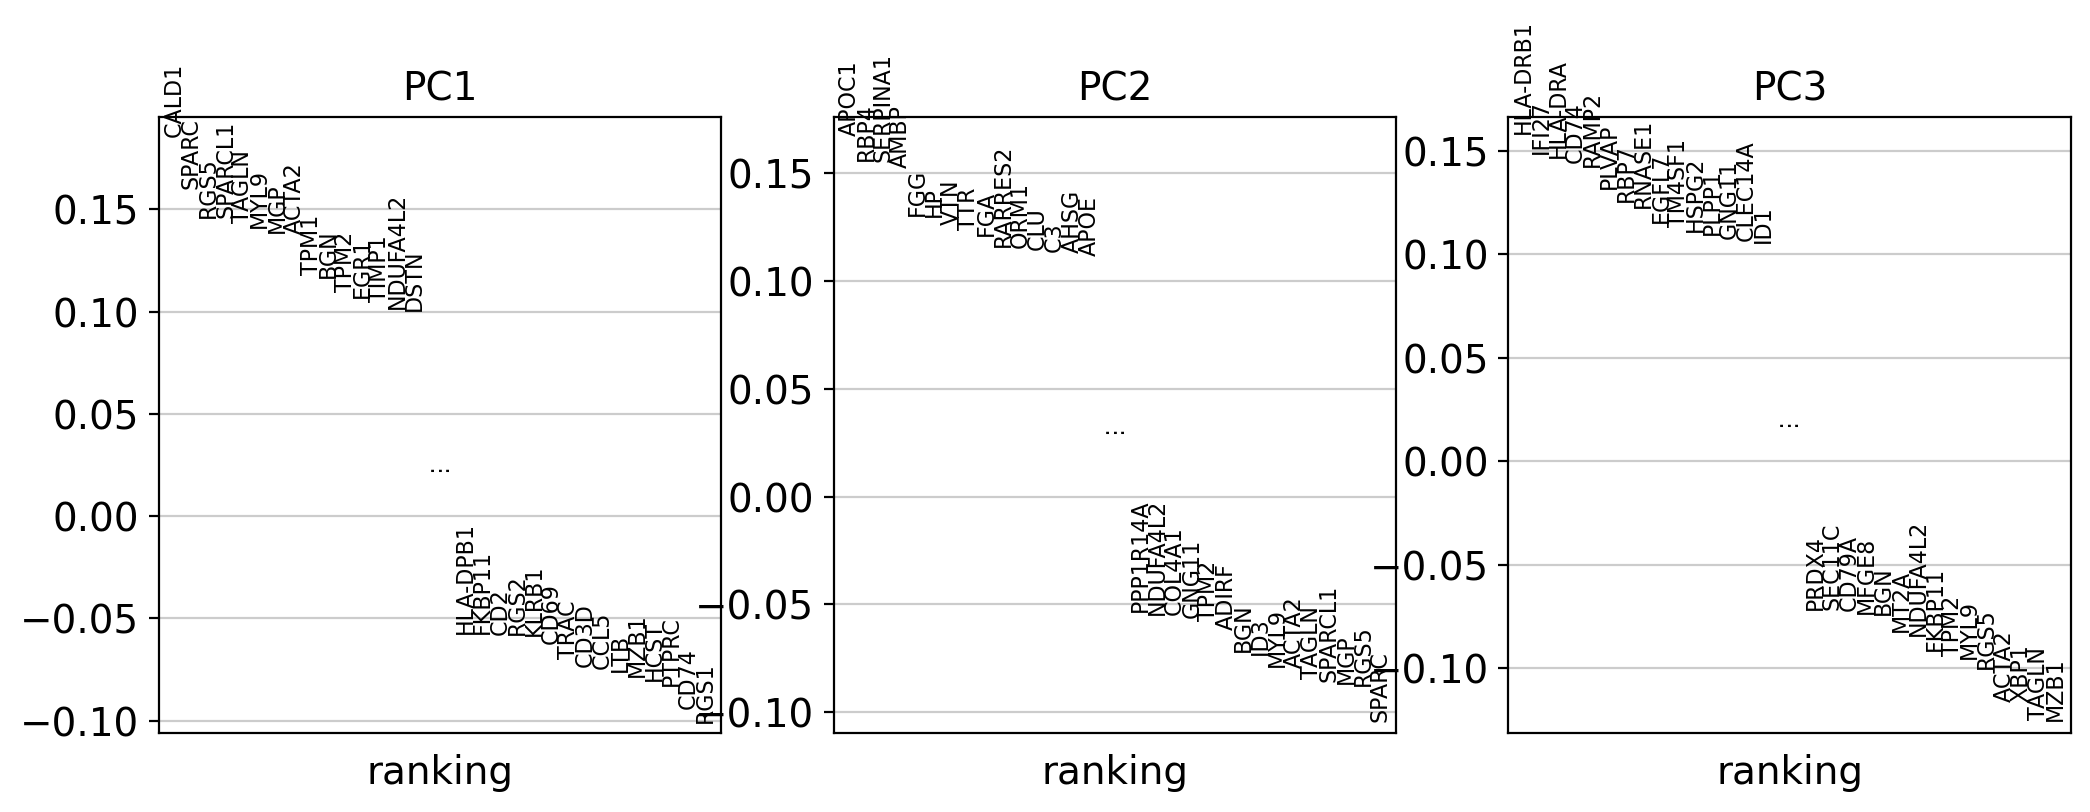

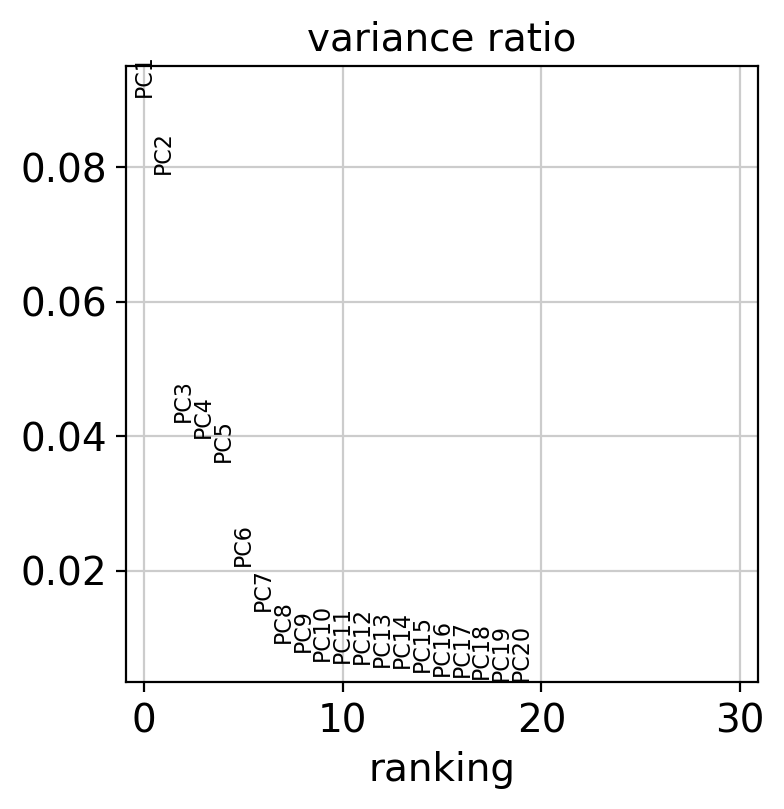

In [34]:
sc.pl.pca_overview(norm_data, color='samples')

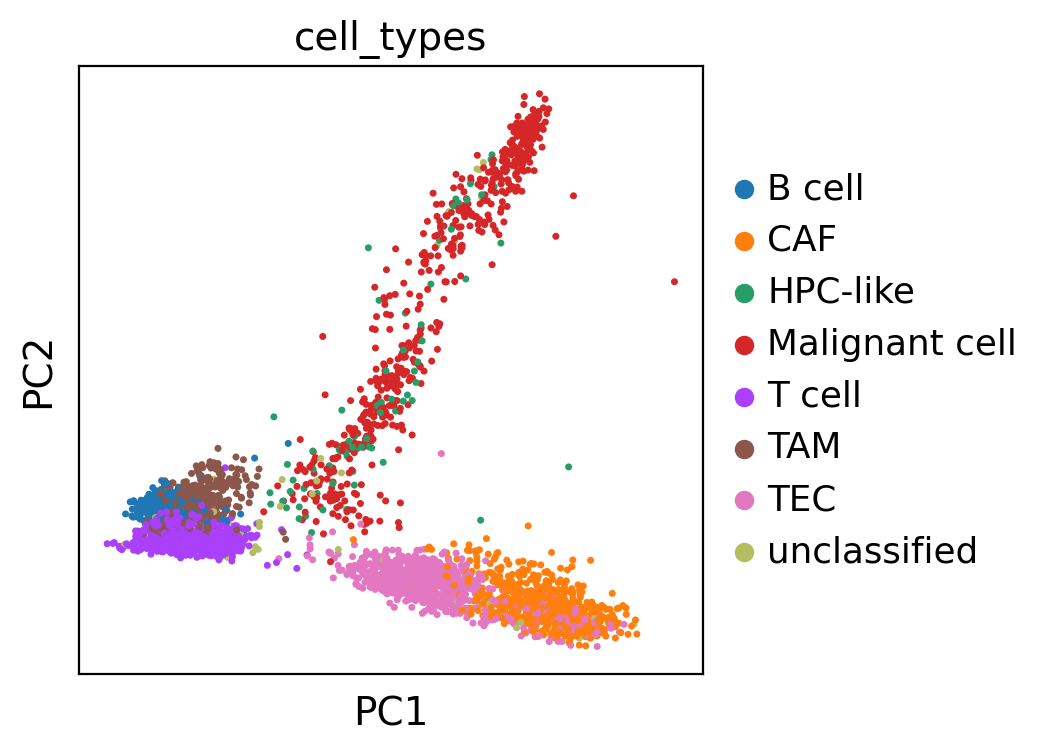

In [36]:
sc.pl.pca(norm_data, color='cell_types')

## Вопрос №6

**Если есть техническая возможность загрузите несколько образцов, проведите исследование, есть ли в образцах аномалии биологического или технического характера (батч-эффект), оформите  скрипт на языке Python или R, можно в формате jupyter notebook.**

Для сравнения, до фильтрации высоковариабельных генов, график главных компонентов выглядел так:
<img src="PCA_raw.png" width=50% height=50% style="float: left; margin-right: 10px;"/>

По графику видно, что наибольшее количество "шума" вносят образцы 2,11,12,15.
Рассмотрим эту ситуацию более подробно.

In [37]:
norm_data2=data_process.copy()
norm_data2.obs["cell_types"] = for_colors['cell_type']
norm_data2.obs["samples"] = for_colors['sample']
sc.pp.normalize_total(norm_data2, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(norm_data2)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100A9', 'S100A8', 'S100A6', 'APOA2', 'TMSB10', 'IGKC', 'MTRNR2L12', 'IGFBP7', 'JCHAIN', 'ALB', 'TMSB4X', 'TIMP1', 'MTRNR2L10', 'CCL19', 'HBB', 'MTRNR2L8', 'SAA2', 'SAA1', 'FTH1', 'MALAT1', 'APOC3', 'LYZ', 'SERPINA1', 'IGHA2', 'IGHG4', 'IGHG2', 'IGHGP', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHV3-23', 'B2M', 'HBA2', 'HBA1', 'HP', 'MTRNR2L1', 'APOE', 'FTL', 'IGLC2', 'IGLC3', 'TFF3', 'TFF1', 'MT-CO1', 'MT-CO2']
    finished (0:00:00)


In [38]:
#проведем вычисление вариабельных генов отдельно для каждого образца
sc.pp.highly_variable_genes(norm_data2, min_mean=0.05, max_mean=3, min_disp=0.5, batch_key = 'samples')
norm_data2.var

extracting highly variable genes


/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/scanpy/preprocessing/_highly

    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


,gene_ids,feature_types,mito,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
RP11-34P13.7,ENSG00000238009,Gene Expression,False,False,0.002869,-0.003284,-0.413745,0,False
FO538757.2,ENSG00000279457,Gene Expression,False,False,0.439257,1.400911,-0.509499,0,False
AP006222.2,ENSG00000228463,Gene Expression,False,False,0.170962,1.133371,-0.000012,0,False
RP4-669L17.10,ENSG00000237094,Gene Expression,False,False,0.016852,0.816852,-0.158248,0,False
RP5-857K21.4,ENSG00000230021,Gene Expression,False,False,0.002736,0.116026,-0.262551,0,False
...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,False,False,0.066250,0.629173,-0.729548,2,False
AC004556.1,ENSG00000276345,Gene Expression,False,False,0.056285,0.366721,-0.553695,1,False
AC233755.2,ENSG00000277856,Gene Expression,False,False,0.036107,0.458713,0.465757,1,False
AC233755.1,ENSG00000275063,Gene Expression,False,False,0.040037,0.261860,0.129158,1,False


In [40]:
# количество пересечений вариабельных генов между образцами
var_genes_batch = norm_data2.var.highly_variable_nbatches > 0
norm_data2.var.highly_variable_nbatches.value_counts()

0     5691
1     4042
2     3140
3     2400
4     1839
5     1205
6      792
7      458
8      273
9      144
10      95
11      41
12       4
Name: highly_variable_nbatches, dtype: int64

In [39]:
# сколько вариабельных генов было выявлено при совместном вычислении:
var_genes_all = norm_data.var.highly_variable
sum(var_genes_all)

2313

In [41]:
# сумма по всем вариабельным генам, вычисленным отдельно в разных группах:
sum(var_genes_batch)

14433

In [42]:
# пересечение
sum (var_genes_batch & var_genes_all)

2306

В дальнейшем для совмещения данных из разных пакетов можно учитывать те гены, которые являются вариабельными в N образцов. 

Например общие высоковариабельные гены, встречающиеся в 4х и более образцах:

In [43]:
var_select = norm_data2.var.highly_variable_nbatches > 4
var_genes = var_select.index[var_select]
len(var_genes)

3012

В scanpy существует несколько алгоритмов пакетной коррекции. Некоторые из них принимают на вход плотную матрицу данных (например, scanpy.pp.combat и scanpy.pp.regress_out) и используют алгоритмы линейной регрессии для устранения предполагаемого пакетного эффекта. Другие (например, scanpy.external.pp.mnn_correct) используют метод взаимных ближайших соседей и, помимо исходной матрицы, требуют список высоковариабельных генов для пакетной коррекции. Чтобы понять, какой из методов будет лучше всего работать с конкретными данными, нужно дополнительно исследовать этот вопрос и протестировать разные способы.

## Вопрос №7

**На примере одного образца, выделите кластера клеток. Как можно охарактеризовать выделенные кластера? Оформите  скрипт на языке Python или R, можно в формате jupyter notebook**

In [45]:
clustering_data=norm_data.copy()
clustering_data_diff=norm_data.copy()

computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE


/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:28)


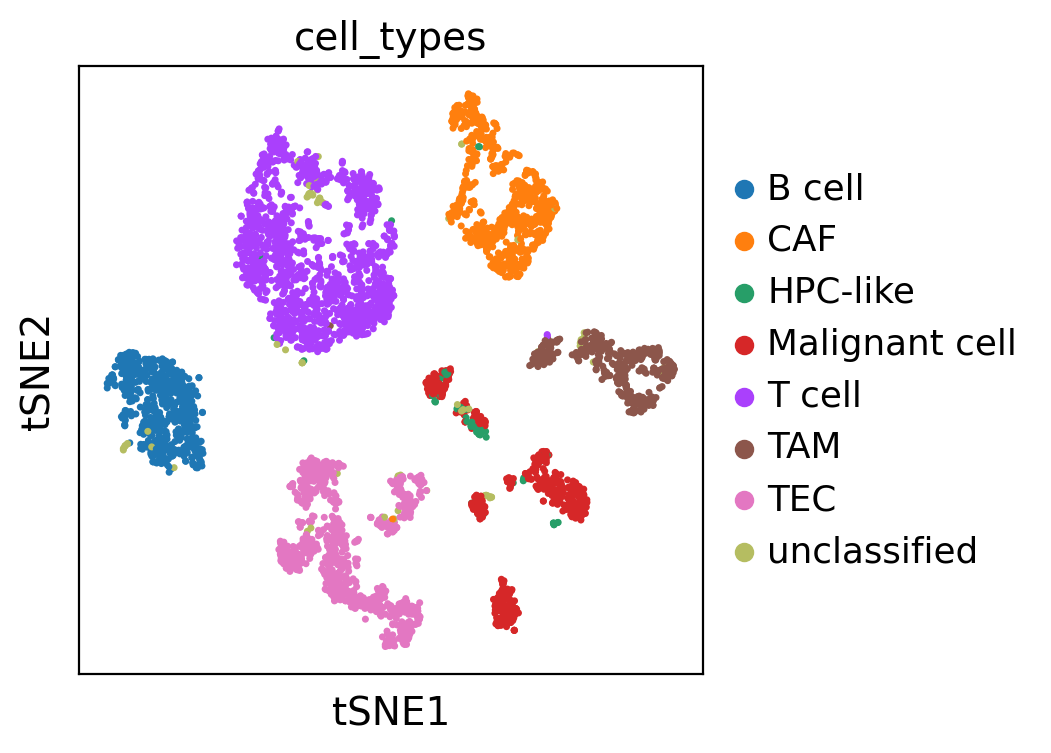

In [46]:
# уменьшение размерности методом t-SNE
sc.tl.tsne(clustering_data, n_pcs=20, perplexity=30, learning_rate=1000, random_state=0)
sc.pl.tsne(clustering_data, color='cell_types')

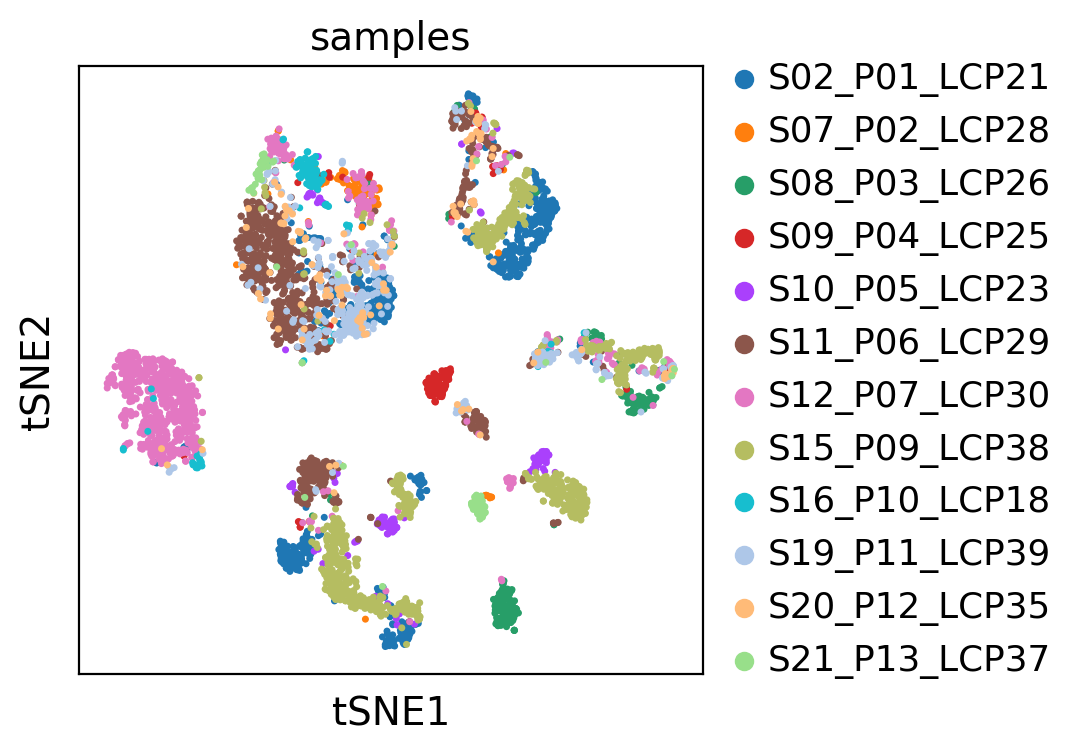

In [47]:
sc.pl.tsne(clustering_data, color='samples')

При использовании метода t-SNE видно, что клетки группируются преимущественно в соответствии с клеточным типом, однако в некоторых группах наблюдается смешение. Попробуем отдельно проанализировать злокачественные и не злокачественные клетки.

In [48]:
non_malignant = clustering_data_diff[~clustering_data_diff.obs['cell_types'].isin(['Malignant cell', 'unclassified']),:]
non_malignant

View of AnnData object with n_obs × n_vars = 4106 × 20124
    obs: 'n_genes', 'n_counts', 'cell_types', 'samples'
    var: 'gene_ids', 'feature_types', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'samples_colors', 'cell_types_colors'
    obsm: 'X_pca'
    varm: 'PCs'

In [49]:
malignant=clustering_data_diff[clustering_data_diff.obs['cell_types'].isin(['Malignant cell']),:]
malignant

View of AnnData object with n_obs × n_vars = 536 × 20124
    obs: 'n_genes', 'n_counts', 'cell_types', 'samples'
    var: 'gene_ids', 'feature_types', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'samples_colors', 'cell_types_colors'
    obsm: 'X_pca'
    varm: 'PCs'

computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE


/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:21)


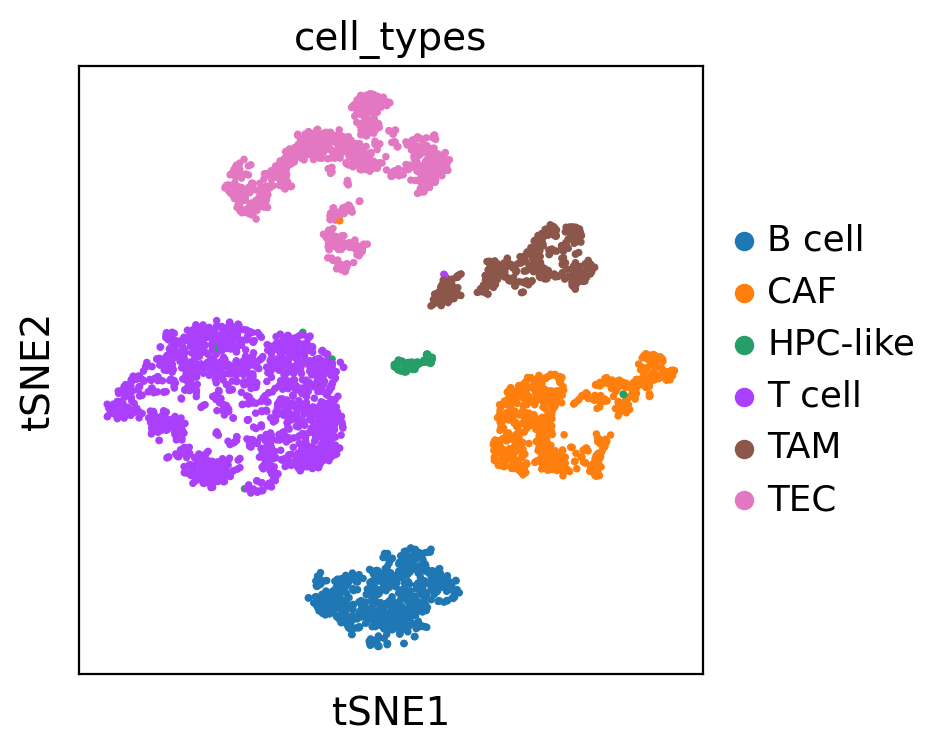

In [50]:
sc.tl.tsne(non_malignant, n_pcs=20, perplexity=30, learning_rate=1000, random_state=0)
sc.pl.tsne(non_malignant, color='cell_types')

computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE


/home/alena/anaconda3/envs/test_work/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:02)


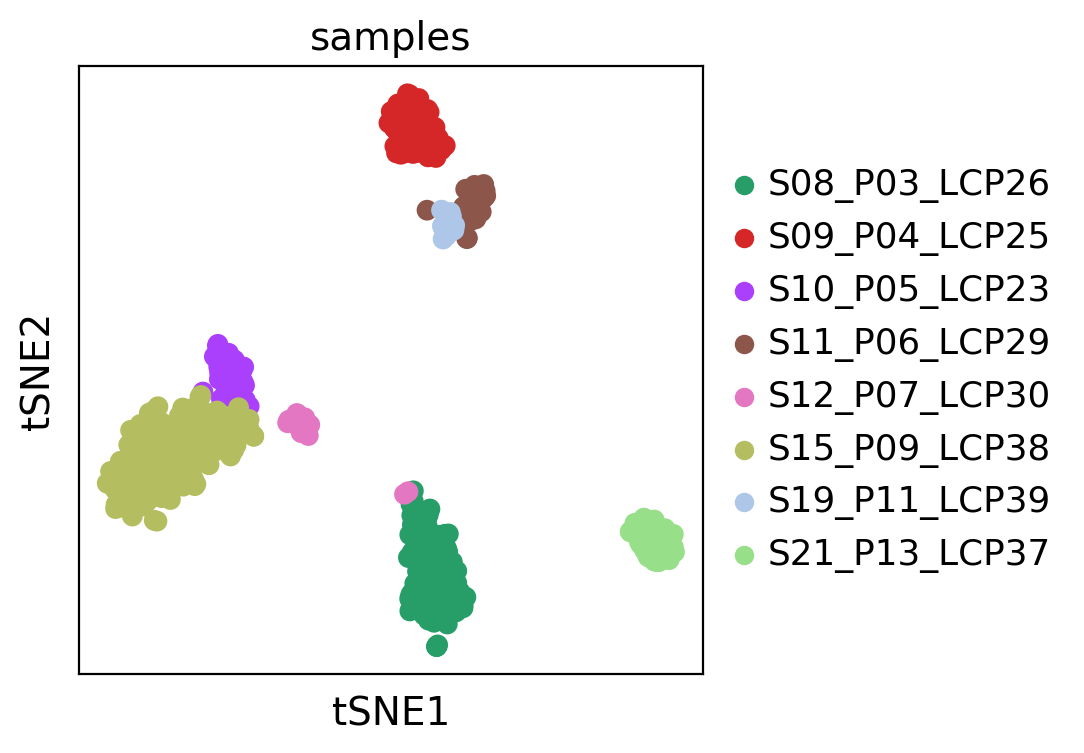

In [51]:
sc.tl.tsne(malignant, n_pcs=20, perplexity=30, learning_rate=1000, random_state=0)
sc.pl.tsne(malignant, color='samples')

При таком разделении группы становятся более однородными. Не злокачественные клетки явно группируются по типу клеток, злокачественные - по большей части в соотвествии с типом образца.
Посмотрим на другой метод уменьшения размерности - UMAP.

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


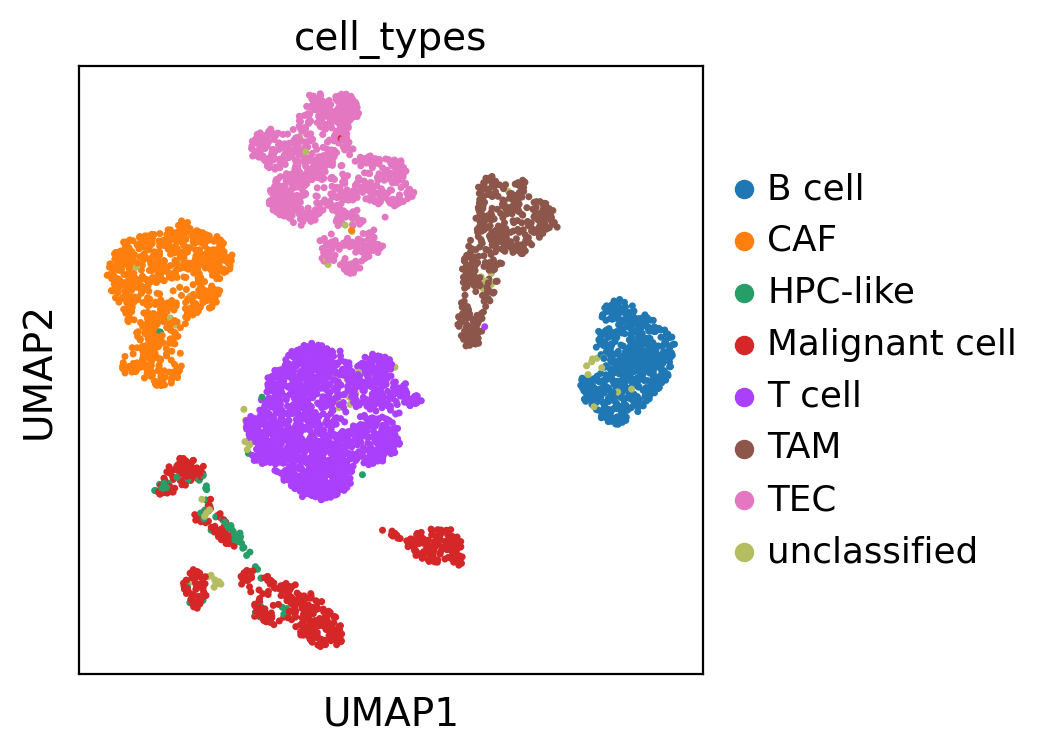

In [52]:
sc.pp.neighbors(clustering_data, n_neighbors = 20, n_pcs = 20)
sc.tl.umap(clustering_data, min_dist=1.0, spread=1.5, random_state=0, n_components=2)
sc.pl.umap(clustering_data, color='cell_types')

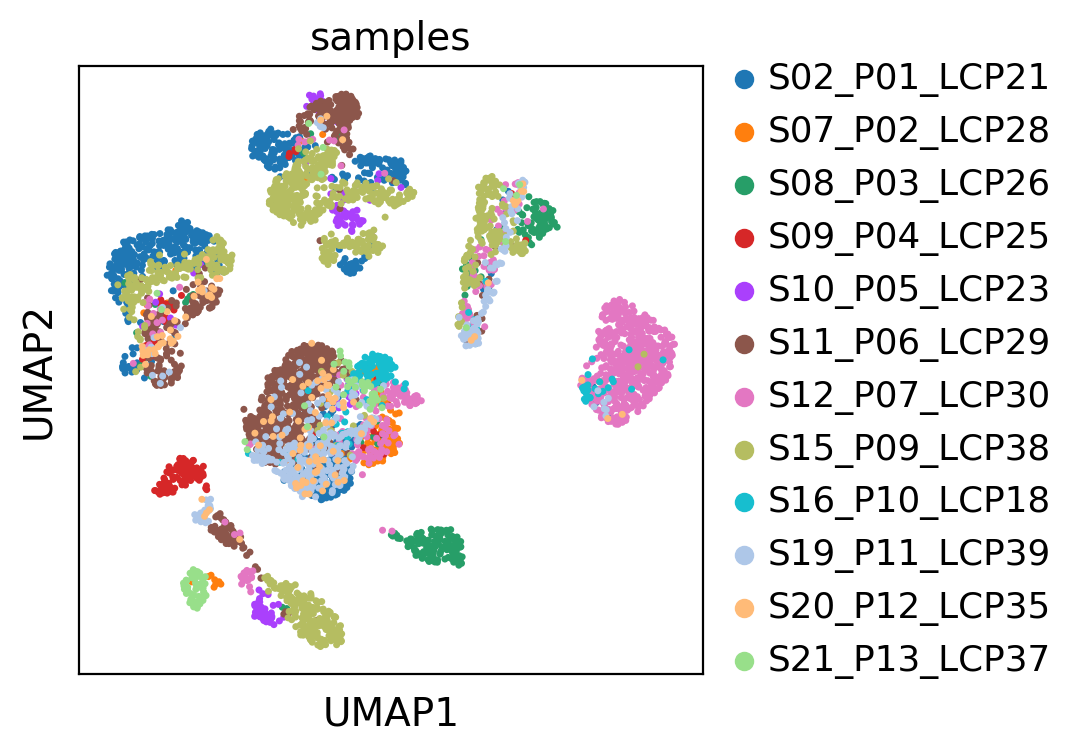

In [53]:
sc.pl.umap(clustering_data, color='samples')

Картина получается довольно похожая на то, что было при применении метода t-SNE. Однако пока это только визуализация, поэтому следующий шаг - кластерзация.

In [54]:
# будем применять кластеризацию методом к-средних
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

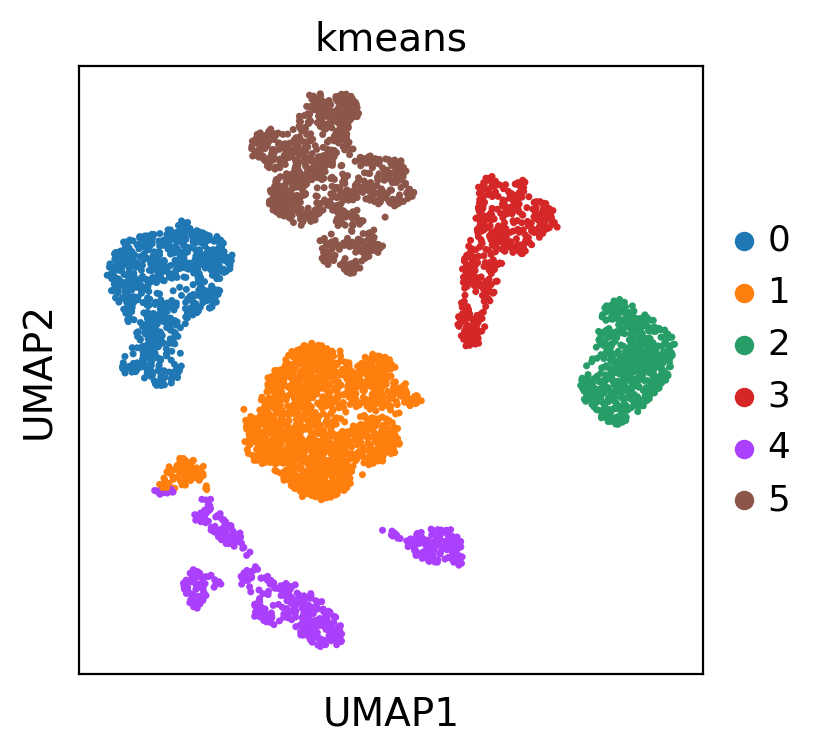

In [62]:
# сначала посмотрим, что получилось при уменьшении размерности методом UMAP
X_pca = clustering_data.obsm['X_umap'] 

kmeans = KMeans(n_clusters=6, random_state=0).fit(X_pca) 
clustering_data.obs['kmeans'] = kmeans.labels_.astype(str)

sc.pl.umap(clustering_data, color=['kmeans'])

In [58]:
# для оценки сходства применим индекс Рэнда
rand_index = adjusted_rand_score(labels_true = clustering_data.obs['cell_types'], labels_pred = clustering_data.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.93


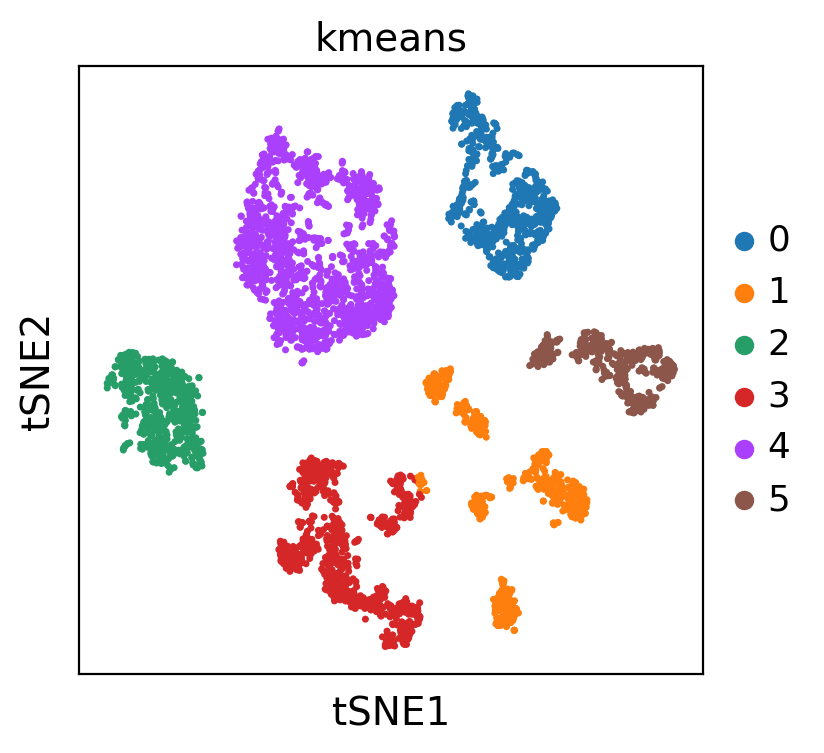

In [63]:
# теперь посмотрим что получилось при уменьшении размерности методом t-SNE
X_pca = clustering_data.obsm['X_tsne'] 

kmeans = KMeans(n_clusters=6, random_state=0).fit(X_pca) 
clustering_data.obs['kmeans'] = kmeans.labels_.astype(str)

sc.pl.tsne(clustering_data, color=['kmeans'])

In [61]:
rand_index = adjusted_rand_score(labels_true = clustering_data.obs['cell_types'], labels_pred = clustering_data.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.95


Здесь результат уже более точный, хотя все равно разделение на кластеры получается довольно грубое и не отображает смешения типов клеток внутри некоторых кластеров.

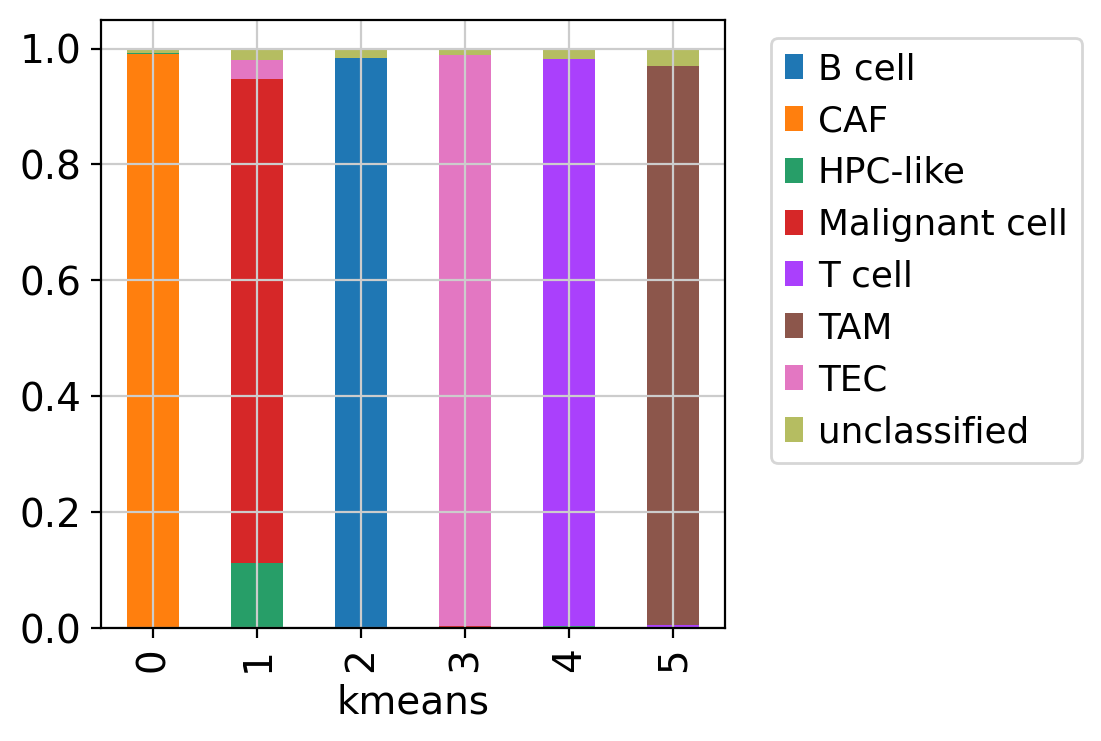

In [65]:
# внутренняя характеристика кластеров
tmp = pd.crosstab(clustering_data.obs['kmeans'],clustering_data.obs['cell_types'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='upper right', bbox_to_anchor=(1.6,1))

## Вопрос №8

**Сравните уровень экспрессии следующих генов между кластерами, STAMBP, miR101-3p, YOD1, miR93-5p. Существует ли корреляция в экспрессии пар генов STAMBP1/miR101-3p, YOD1/miR93-5p внутри одного кластера? Между кластерами?  Оформите  скрипт на языке Python или R, можно в формате jupyter notebook.**

**STAMBP** или STAM-binding protein участвует в опосредованной цитокинами передаче сигнала в каскаде для индукции MYC в ходе клеточного цикла. Ген экспрессируется в большом количестве тканей организма, в том числе в печени.

**YOD1** деубиквитиназа принадлежит семейству деубиквиинирующих ферментов DUB и участвует в процессах отщепления убиквитина от белковых субстратов, также широко экспрессируется в организме.

**miR** в общем смысле - микроРНК, разновидностей которых существует огромное количество. Некоторые из них играют решающую роль при канцерогенезе и опухолевой прогрессии, участвуя в этих процессах в качестве регуляторов эксрессии генов.

В некоторых статьях встречается упоминание **miR101-3p** и **miR93-5p** в качестве регуляторов процесса развития гепатоцеллюлярной карциномы. Тем не менее, в данном датасете эти РНК отсутствуют. Причиной этому могут быть ограничения самого процесса секвенирования РНК одиночных клеток. 

Во первых, эффективность лигировария адаптера (поли-А хвоста) может сильно варьировать, в зависимости от последовательности микроРНК и ее вторичной структуры. В случае низкой эффективности лигирования адаптеров, транскрипты обнаруживаться не будут.

Во вторых, если выборка клеток, в которых экспрессируется конкретный транскрипт, сильно ограничена, полноценная характеристика профилей транскрипции внутри этой популяции может быть затруднена, если из каждой клетки не будет захвачено минимально необходимое количество РНК.

То есть если исходить из предположения, что **miR101-3p** и **miR93-5p** все же экспрессируются в образцах, они не были обнаружены с помощью данной технологии секвенирования.

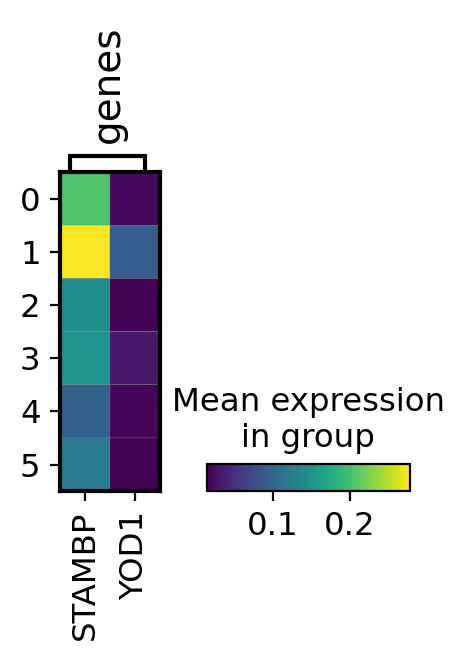

In [70]:
# сравнение средней экспрессии генов по кластерам
genes = {'genes':['STAMBP', 'YOD1']}
sc.pl.matrixplot(clustering_data, genes, groupby='kmeans')

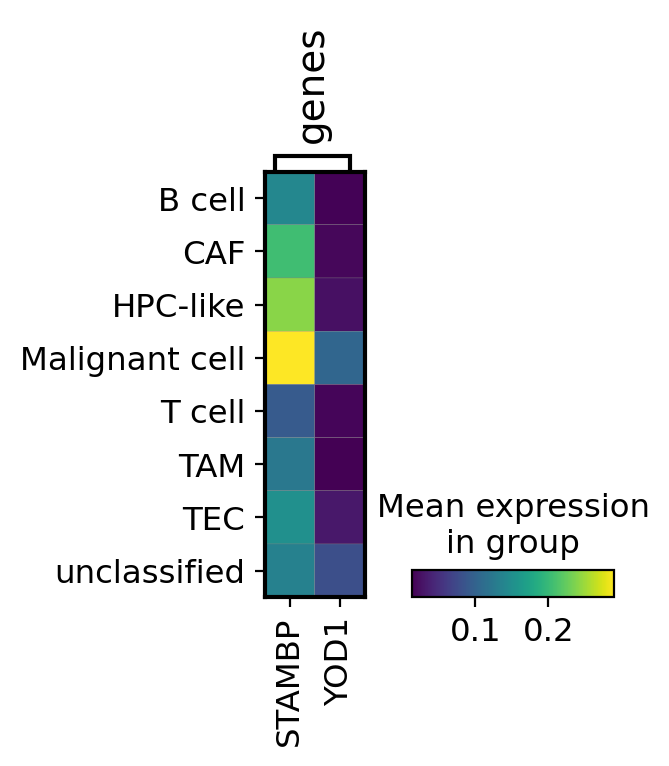

In [71]:
# по типам клеток
sc.pl.matrixplot(clustering_data, genes, groupby='cell_types')

Видно, что экспрессия обоих генов у злокачественных клеток выше по сравнению с не злокачественными, а экспрессия STAMBP в среднем выше, чем YOD1. Так как 2й кластер содержит в себе, по большей части, злокачественные клетки, далее будем сравнивать экспрессию генов интереса относительно него. 

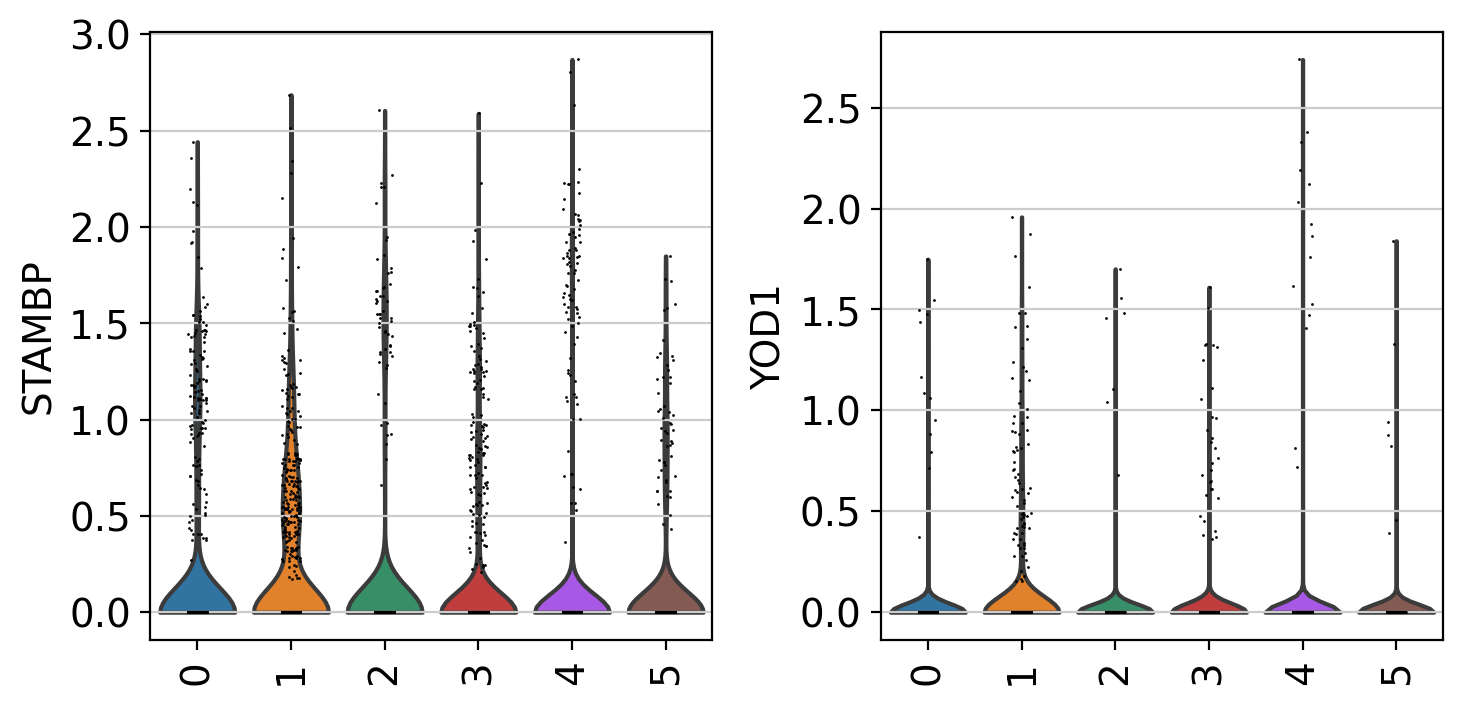

In [83]:
# посмотрим на то же самое в формате другого графика. Видно что в большинстве клеток эти гены не экспрессируются.
sc.pl.violin(clustering_data, keys=['STAMBP', 'YOD1'], groupby='kmeans', rotation=90, stripplot=True)

In [85]:
expr_data=pd.DataFrame(data=clustering_data.X.toarray(), index=clustering_data.obs_names, columns=clustering_data.var_names)
expr_data

,RP11-34P13.7,FO538757.2,AP006222.2,RP4-669L17.10,RP5-857K21.4,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,...,AC145212.2,AC011043.1,AL592183.1,AC007325.1,AC007325.4,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
AAACCTGAGGCGTACA-1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGGGAGATCGATA-1,0.000000,0.000000,1.448642,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCAAAGATCGGGT-1,0.000000,0.892291,0.000000,0.0,0.0,0.000000,0.892291,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAATGCCGTCTCAACA-1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACACGTCACGGCTAC-1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGACTTTCCAGTAGT-13,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGCCGTCATCGACGC-13,0.173221,0.563332,0.000000,0.0,0.0,0.173221,0.000000,0.0,0.0,0.0,...,0.000000,0.173221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGGAACTCGAACTGT-13,0.000000,0.754899,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.754899,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTATGCTCCTTAATC-13,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
expr_detail=expr_data.merge(clustering_data_diff.obs['cell_types'], left_index=True, right_index=True).set_index('cell_types')
expr_detail

,RP11-34P13.7,FO538757.2,AP006222.2,RP4-669L17.10,RP5-857K21.4,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,...,AC145212.2,AC011043.1,AL592183.1,AC007325.1,AC007325.4,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
cell_types,,,,,,,,,,,,,,,,,,,,,
CAF,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAF,0.000000,0.000000,1.448642,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAF,0.000000,0.892291,0.000000,0.0,0.0,0.000000,0.892291,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAF,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TEC,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T cell,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Malignant cell,0.173221,0.563332,0.000000,0.0,0.0,0.173221,0.000000,0.0,0.0,0.0,...,0.000000,0.173221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Malignant cell,0.000000,0.754899,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.754899,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# посмотрим в скольких клетках экспрессируется ген (имеет ненулевые значения экспрессии)
expr_detail['STAMBP'].sort_values().to_frame().query('STAMBP>0')

,STAMBP
cell_types,
Malignant cell,0.174417
Malignant cell,0.179016
Malignant cell,0.179804
TEC,0.183266
Malignant cell,0.190537
...,...
B cell,2.605008
T cell,2.634519
Malignant cell,2.686479


In [94]:
# и посчитаем количество клеток каждого типа, в которых ген экспрессируется
expr_detail['STAMBP'].to_frame().query('STAMBP>0').groupby('cell_types').agg({'STAMBP':'count'}).sort_values('STAMBP',ascending=False)

,STAMBP
cell_types,
Malignant cell,211
TEC,144
CAF,132
T cell,81
B cell,53
TAM,52
HPC-like,18
unclassified,15


In [96]:
# то же самое для другого гена
expr_detail['YOD1'].sort_values().to_frame().query('YOD1>0')

,YOD1
cell_types,
Malignant cell,0.153825
Malignant cell,0.155738
Malignant cell,0.162762
Malignant cell,0.179016
Malignant cell,0.205946
...,...
T cell,2.123261
T cell,2.192969
T cell,2.330692


In [97]:
expr_detail['YOD1'].to_frame().query('YOD1>0').groupby('cell_types').agg({'YOD1':'count'}).sort_values('YOD1',ascending=False)

,YOD1
cell_types,
Malignant cell,77
TEC,32
T cell,13
CAF,12
B cell,7
TAM,6
unclassified,5
HPC-like,2


In [98]:
# сравним экспрессию этих генов между вторым кластером и всеми остальными клетками
cluster2 = expr_data[clustering_data.obs['kmeans'] == '2']
not_cluster2 = expr_data[clustering_data.obs['kmeans'] != '2']

In [99]:
cluster2_yod1_exp = cluster2['YOD1'] 
not_cluster2_yod1_exp = not_cluster2['YOD1'] 

cluster2_stambp_exp = cluster2['STAMBP'] 
not_cluster2_stambp_exp = not_cluster2['STAMBP'] 

In [100]:
from scipy.stats import ttest_ind     #t-test
ttest = ttest_ind(cluster2_yod1_exp, 
          not_cluster2_yod1_exp, 
          equal_var=False,
          nan_policy='omit')
print(ttest)

Ttest_indResult(statistic=-2.641272234136409, pvalue=0.008393001050376171)


In [101]:
ttest = ttest_ind(cluster2_stambp_exp, 
          not_cluster2_stambp_exp, 
          equal_var=False,
          nan_policy='omit')
print(ttest)

Ttest_indResult(statistic=-0.6974047015469222, pvalue=0.48576521205979817)


В случае сравнения кластеров, только ген YOD1 показывает достоверные различия в экспрессии (p-val<0.01).
Попробуем предметно посмотреть на типы клеток, независимо от кластеров.

In [103]:
malignant = expr_data[clustering_data.obs['cell_types'] == 'Malignant cell']
not_malignant = expr_data[clustering_data.obs['cell_types'] != 'Malignant cell']

In [104]:
malignant_yod1_exp = malignant['YOD1'] 
not_malignant_yod1_exp = not_malignant['YOD1'] 

malignant_stambp_exp = malignant['STAMBP'] 
not_malignant_stambp_exp = not_malignant['STAMBP'] 

In [105]:
ttest = ttest_ind(malignant_yod1_exp, 
          not_malignant_yod1_exp, 
          equal_var=False,
          nan_policy='omit')
print(ttest)

Ttest_indResult(statistic=6.262069953776289, pvalue=7.409920344552162e-10)


In [106]:
ttest = ttest_ind(malignant_stambp_exp, 
          not_malignant_stambp_exp, 
          equal_var=False,
          nan_policy='omit')
print(ttest)

Ttest_indResult(statistic=7.48205627617292, pvalue=2.346691752487827e-13)


В результате, посчитанный p-val получился на несколько порядков ниже. Возможно, здесь играет роль присутствие смеси разных типов клеток внутри кластеров.